# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install seaborn
!python -m pip install scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Loading Data and Subdividing into Smaller Batches

In [31]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
# creates an overlap of two months between subsets
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))

# Intensity Estimation

## Method 1: Intensity Based on `total.counts`

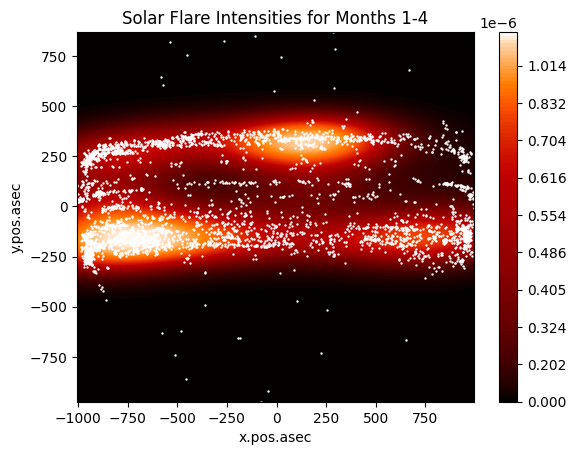

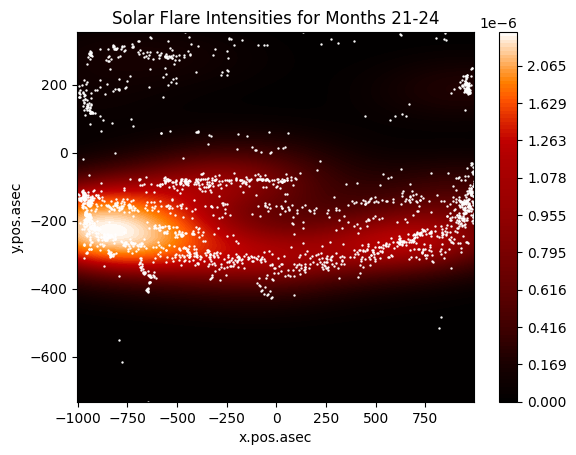

In [43]:
def intensity_estimation(data, plot=False, levels=10):
    # getting the x, y, and total.counts values in numpy arrays
    x = data['x.pos.asec'].values.flatten()
    y = data['y.pos.asec'].values.flatten()
    counts = data['total.counts'].values.flatten()
    
    if plot:
        # new matplotlib figure
        plt.figure()

        # seaborne kde plot, uses scipy gaussian_kde underneath
        ax = sns.kdeplot(data=data, x='x.pos.asec', y='y.pos.asec', 
                           weights='total.counts', fill=True, levels=levels, 
                           thresh=0, cmap='gist_heat', cbar=True)
        
        # retrieving the tick values for the colorbar, can be used as threshold values 
        ticks = ax.collections[-1].colorbar.get_ticks()

        # adjusting domain and range
        plt.xlim(x.min(), x.max())
        plt.ylim(y.min(), y.max())

        # title
        plt.title(f"Solar Flare Intensities for Months {data['month'].min()}-{data['month'].max()}")

        # plotting the scatterplot on top of the kde plot
        plt.scatter(x, y, s=0.5, facecolor='white')
        
        # saving the figure to the output folder
        date_range = f"{data['year'].iloc[0]}_{data['month'].min()}-{data['month'].max()}"
        plt.savefig(f"./output/intensity_frequency{date_range}.png")

        # return the values for the contours, which can serve as threshold values for hotspot analysis
        return ticks
    else:
        # data from the subset to be passed to gaussian kernel
        training_locations = np.vstack([x, y])

        # gaussian kernel, bandwidth using "scott's rule", using the total.counts attribute as weights
        kde = stats.gaussian_kde(training_locations, bw_method='scott', weights=counts.T)

        # returning the intensity values for each location
        return kde.evaluate(training_locations)
    
# performing the intesity estimation on months 1-4 and 21-24
s1 = dfs[0]
s2 = dfs[-1]

a = intensity_estimation(s1, plot=True, levels=100)
b = intensity_estimation(s2, plot=True, levels=100)

## Method 2: Intensity Based on `duration.s` and `energy.kev`